# Bootstrapping 

This notebook explores some simple example of bootstrapping statistical estimates, primarily around computing confidence estimates. 

By `bootstrapping` we mean random resampling, with replacement, to estimate sample distributions. 

Wiki: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from bootstrap import *

## Bootstrapped Confidence Intervals

Confidence Intervals indicate the range of plausible values for an estimated value. 

Confidence Intervals: https://en.wikipedia.org/wiki/Confidence_interval

In [2]:
# Settings for simulated data
n = 1000
corr_val = 0.75
covs = [[1, corr_val], [corr_val, 1]]
means = [0, 0]

# Generate the data
x, y = np.random.multivariate_normal(means, covs, n).T

In [3]:
## Bootstrap settings 

# Set which correlation function to use
corr_func = spearmanr

# Set the alpha level
alpha = 0.05

# Set the number of resamples to perform in the bootstrapping
n_samples = 5000

In [4]:
# Calculate the estimated correlation between the data
r, p = corr_func(x, y)
print('R-val: {:1.4f} \t p-val: {:1.4f}'.format(r, p))

R-val: 0.7347 	 p-val: 0.0000


In [5]:
# Resample bootstraps
bootstrap_x, bootstrap_y = sample_bootstrap(n_samples, x, y)

# Compute estimates across resamples
estimates = compute_bootstrap_estimates(bootstrap_x, bootstrap_y, corr_func)
    
# Compute confidence intervals from bootstrapped distribution
cis = compute_cis(estimates, alpha)

In [6]:
# Check the computed confidence interval
print('Computed confidence interval: [{:1.4f}, {:1.4f}]'.format(*cis))

Computed confidence interval: [0.7008, 0.7646]


We can plot our bootstrapped distribution of estimates. 

In the plot below, the dashed black line is the mean of the distribution, and the red lines are the computed confidence intervals. 

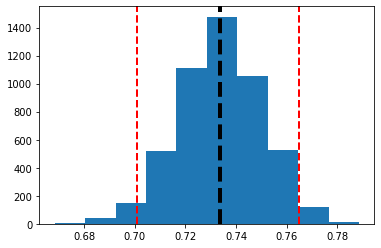

In [7]:
# Plot the bootstrapped distribution of correlation values
plot_bootstrap(estimates, cis)

### Analytic Confidence Intervals

Note that for correlations, there can be analytically computed confidence intervals. 

The module `pingouin` computes these, which we can compare to our bootstrapped estimates.

In [8]:
from pingouin import corr

In [9]:
out = corr(x, y, method='spearman')
out

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,1000,0.734696,"[0.7, 0.76]",0.539779,0.538855,2.271241e-170,1.0


In [10]:
out['CI95%']

spearman    [0.7, 0.76]
Name: CI95%, dtype: object

## Bootstrapping a Difference Measure

Next we'll consider the case of bootstrapping the difference between two measures. 

This could be done for many different estimates (for example, differences in group means). 

Here we test the difference in measured correlation values. 

Specifically, given data arrays A, B, C, we can to ask if there is a difference in the correlation values between AB & AC. 

In [11]:
# Settings for simulated data
n = 5000
means = [0, 0, 0]

corr_ab = 0.50
corr_ac = 0.55
corr_bc = 0.75

covs = [[1, corr_ab, corr_ac],
        [corr_ab, 1, corr_bc],
        [corr_ac, corr_bc, 1]]

In [12]:
# Simulate arrays of data with correlations between them
a, b, c = np.random.multivariate_normal(means, covs, n).T

In [13]:
# Calculate corr values between each array
r_ab, p_ab = corr_func(a, b)
r_ac, p_ac = corr_func(a, c)
r_bc, p_bc = corr_func(b, c)

print('Corr AB: {:1.4f}, {:1.4f}'.format(r_ab, p_ab))
print('Corr AC: {:1.4f}, {:1.4f}'.format(r_ac, p_ac))
print('Corr BC: {:1.4f}, {:1.4f}'.format(r_bc, p_bc))

Corr AB: 0.4838, 0.0000
Corr AC: 0.5138, 0.0000
Corr BC: 0.7359, 0.0000


In [14]:
# Calculate the difference of correlation of interest
r_diff = r_ab - r_ac
print('Measured difference in correlation: {:1.4f}'.format(r_diff))

Measured difference in correlation: -0.0299


We have measured the difference in correlations. 

However, there is no obvious way, from this measure, to know if it represents a meaningful difference. 

To ask that question, we will bootstrap a distribution of difference measures. 

In [15]:
# Sample bootstraps
bootstrap_a, bootstrap_b, bootstrap_c = sample_bootstrap(n_samples, a, b, c)

In [16]:
# Compute estimates
corrs_ab = compute_bootstrap_estimates(bootstrap_a, bootstrap_b, corr_func)
corrs_ac = compute_bootstrap_estimates(bootstrap_a, bootstrap_c, corr_func)

In [17]:
# Calculate differences across all the estimates
diffs = corrs_ab - corrs_ac

In [18]:
# Calculate the confidence intervals of the difference measure
cis = compute_cis(diffs, alpha)

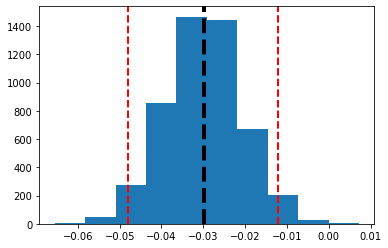

In [19]:
# Plot the distribution of calculated difference estimates
plot_bootstrap(diffs, cis)

Now that we have a distribution of difference measures, we can measure our level of confidence in the measured difference, and the range of plausible values. 

Since we have a distribution of difference measures, we can also compute an empirical p-value. 

This can test against a null hypothesis, for example, if the difference significantly different from 0. 

In [20]:
# Check the estimate p value of the difference
#   This test against null hypothesis of 0 difference
p_val = compute_pvalue(diffs)
print(p_val)

0.0016000000000000458


### Analytic Confidence Intervals

Note that there is also an analytic solution to comparing differences of correlations: Steiger's test.